In [6]:
# Import modules 
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from scipy.stats import shapiro, wilcoxon, mannwhitneyu

%matplotlib inline
%run "C:\Users\anasofiaccruz\Desktop\cingulate_silencing_repo\data_prep_functions.ipynb"
%run "C:\Users\anasofiaccruz\Desktop\cingulate_silencing_repo\data_analysis_functions.ipynb"

#### <font color='darkorange'> Read the data (test runs below 15 seconds)

In [1]:
file_path = "C:/Users/anasofiaccruz/Desktop/Optogenetics processed data/below15_runs.csv"
below15 = pd.read_csv(file_path)
below15.head(3)

NameError: name 'pd' is not defined

#### <font color='darkorange'>Remove pre-illuminated trials


In [8]:
below15 = below15[(below15['stim_condition']!=-1)]
below15['stim_condition'].unique()

array([1, 3, 0], dtype=int64)

#### <font color='darkorange'> Calculate the performances for each rat, session and condition

In [9]:
# Calculate performances for each rat, session and stimulation condition
session_perfs = below15.groupby(['group','rat','session', 'stim_condition']).apply(calc_performance_in_group)
session_perfs = session_perfs.reset_index().rename(columns={0:'performance'})

In [10]:
# Calculate the overall pooled performance (all sessions combined)
pooled_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition'])['performance'].mean().reset_index()

In [11]:
pooled_perfs.head(5)

,group,rat,stim_condition,performance
0,CTRL,CTRL2,0,78.904762
1,CTRL,CTRL2,3,80.128668
2,CTRL,CTRL3,0,81.851852
3,CTRL,CTRL3,1,80.370370
4,CTRL,CTRL3,3,73.219577


#### <font color='darkorange'> Combined performance within each group

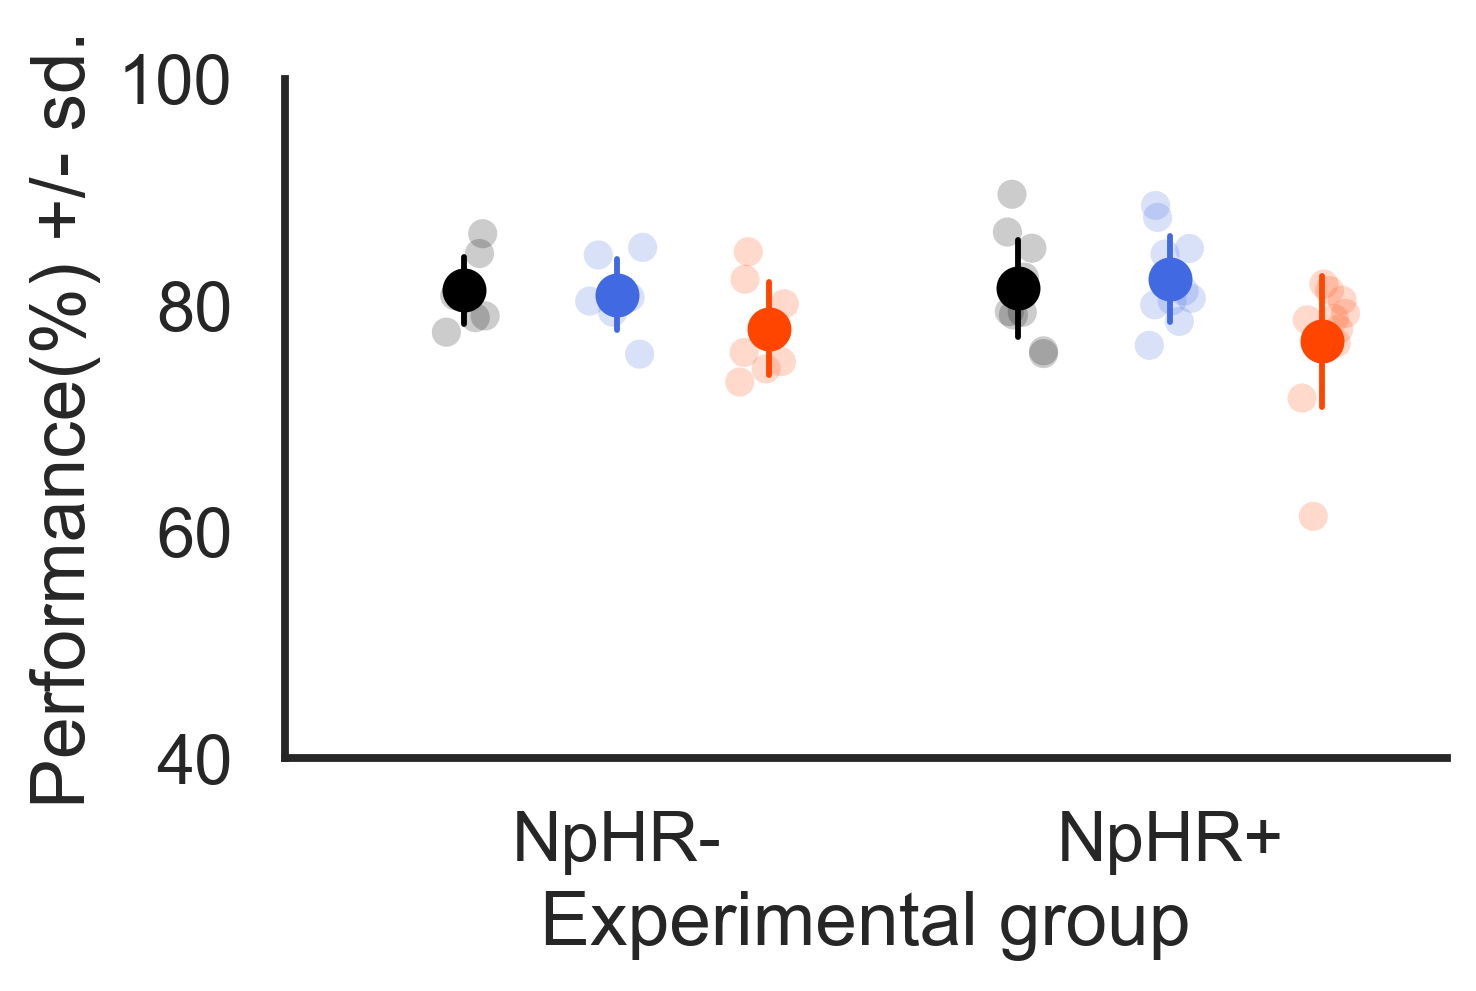

In [12]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(5,3), dpi=300)

g = sns.stripplot(
    data=pooled_perfs, x='group', y='performance', 
    hue=pooled_perfs['stim_condition'].map({0:'None', 1:'Sample', 3:'Test'}),
    hue_order=['None','Sample', 'Test'], dodge=2, jitter=.15, alpha=.2, s=7, 
    palette=['black', 'royalblue', 'orangered'], order=['CTRL', 'NPHR']
)
# Show means
sns.pointplot(
    x='group', y='performance', hue='stim_condition',
    data=pooled_perfs, dodge=.55, join=False, markers="o", scale=.8, 
    estimator=np.mean, ci="sd", errwidth=1.4, palette=['black','royalblue', 'orangered'],
    order=['CTRL', 'NPHR'], legend=False
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Experimental group',
    ylim=(40, 100), xlim=(-0.6, 1.5), xticks=[0,1], xticklabels= ['NpHR-', 'NpHR+'],
    #title='Perfrmance in non-illuminated and test illuminated trials \n'
)

g.legend_.remove()
sns.despine()

###  Inference testing

CTRL  0        (0.934409499168396, 0.5889925956726074)
      1       (0.9386391043663025, 0.6482535004615784)
      3      (0.8992706537246704, 0.32658737897872925)
NPHR  0        (0.9476720690727234, 0.641046404838562)
      1       (0.9441835284233093, 0.6004306077957153)
      3    (0.7464005947113037, 0.0032261130400002003)
dtype: object

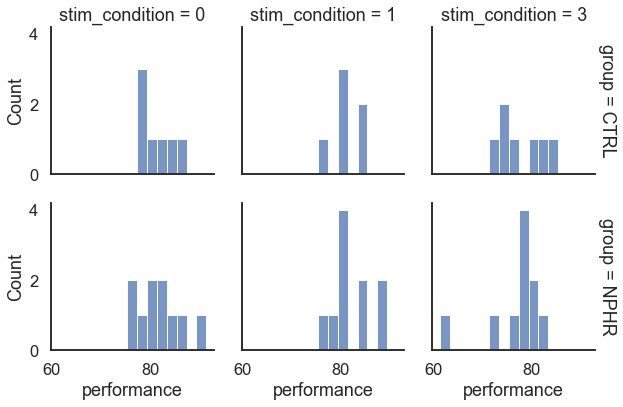

In [13]:
sns.displot(pooled_perfs, x="performance", col="stim_condition", row="group",
            binwidth=2, height=3, facet_kws=dict(margin_titles=True))

normality_testing = {}
for group, data in pooled_perfs.groupby(['group', 'stim_condition'])['performance']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)
normality_testing = pd.Series(normality_testing)
normality_testing

#### The shapiro-Wilk test has confirmed that all but one distribution (NpHR+ , illumination condition) could have been withdrawn from a normal distribution (checked visually above too). Because for one of the distributions the null hypothesis was rejected, I performed two transformations in the four data distributions from pooled performance - square-root and log(e)/(10). I found that these transformations did not transform the NPHR+/illumination distribution into a distribution of data points that could have been withdrawn from a normal distribution, which was confirmed by the shapiro-Wilk test. I will resort to a non-parametric test, namely the Wilcoxon signed rank test, to compare the performance of subjects within each group, across the two experimental conditions. (two-tailed)

In [14]:
# NpHR - group
ctrl_no = pooled_perfs[(pooled_perfs['group']=='CTRL') & (pooled_perfs['stim_condition']==0)]
ctrl_sample = pooled_perfs[(pooled_perfs['group']=='CTRL') & (pooled_perfs['stim_condition']==1)] 
ctrl_test = pooled_perfs[(pooled_perfs['group']=='CTRL') & (pooled_perfs['stim_condition']==3)]

In [15]:
wilcoxon(ctrl_no['performance'], ctrl_test['performance'])

WilcoxonResult(statistic=1.0, pvalue=0.03125)

In [16]:
# Remove CTRL2 No illumination performance
ctrl_no = ctrl_no[ctrl_no['rat']!='CTRL2']

In [17]:
wilcoxon(ctrl_no['performance'], ctrl_sample['performance'])

WilcoxonResult(statistic=5.0, pvalue=0.3125)

In [18]:
# NpHR+ group
nphr_no = pooled_perfs[(pooled_perfs['group']=='NPHR') & (pooled_perfs['stim_condition']==0)]
nphr_sample = pooled_perfs[(pooled_perfs['group']=='NPHR') & (pooled_perfs['stim_condition']==1)]
nphr_test = pooled_perfs[(pooled_perfs['group']=='NPHR') & (pooled_perfs['stim_condition']==3)]

In [19]:
wilcoxon(nphr_no['performance'], nphr_sample['performance'], alternative='two-sided')

WilcoxonResult(statistic=22.0, pvalue=0.625)

In [20]:
wilcoxon(nphr_no['performance'], nphr_test['performance'], alternative='two-sided')

WilcoxonResult(statistic=2.0, pvalue=0.005859375)

#### <font color='darkorange'> Individual condition performances within each group

<Figure size 1800x1200 with 0 Axes>

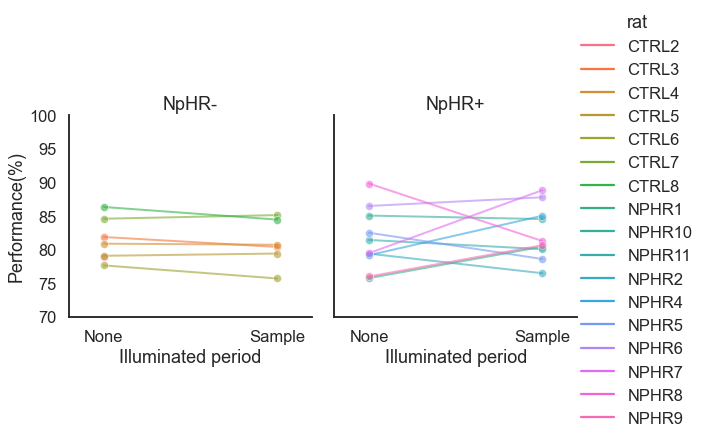

In [21]:
sns.set(style="white", context='talk')    
plt.figure(dpi=300)
colors = ['lightgray']*17 # Needs adjusting as more rats are added
none_vs_sample = pooled_perfs[pooled_perfs['stim_condition']!=3]
g = sns.relplot(
    data=none_vs_sample, col='group',
    x='stim_condition', y='performance', hue='rat', kind='line',
    linewidth=2, marker='o', markersize=8, alpha=.6,
    height=4, aspect=1, #palette=colors
)
g.set(
    ylabel='Performance(%)', xlabel='Illuminated period',
    ylim=(70, 100), xlim=(-.2, 1.2), xticks=[0,1],
    xticklabels=['None', 'Sample']
)
axes = g.axes.flatten()
axes[0].set_title("NpHR-")
axes[1].set_title("NpHR+")
sns.despine()

<Figure size 1800x1200 with 0 Axes>

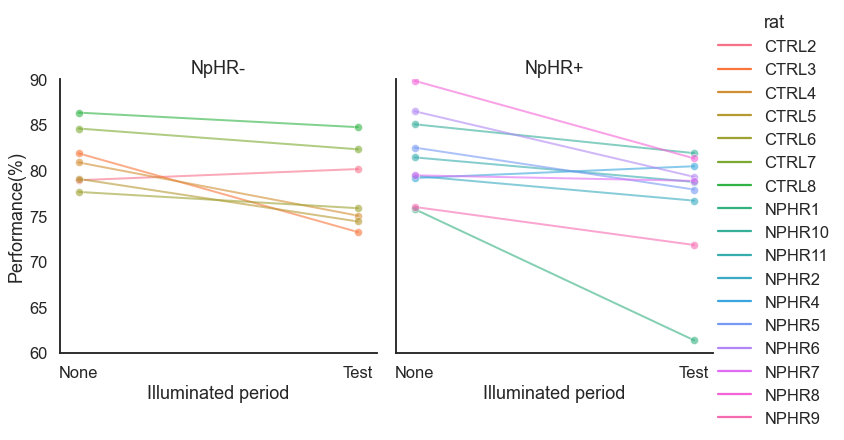

In [22]:
sns.set(style="white", context='talk')    
plt.figure(dpi=300)
colors = ['lightgray']*17 # Needs adjusting as more rats are added
none_vs_sample = pooled_perfs[pooled_perfs['stim_condition']!=1]
g = sns.relplot(
    data=none_vs_sample, col='group',
    x='stim_condition', y='performance', hue='rat', kind='line',
    linewidth=2, marker='o', markersize=8, alpha=.6,
    height=5, aspect=1, #palette=colors
)
g.set(
    ylabel='Performance(%)', xlabel='Illuminated period',
    ylim=(60, 90), xlim=(-.2, 3.2), xticks=[0,3],
    xticklabels=['None', 'Test']
)
axes = g.axes.flatten()
axes[0].set_title("NpHR-")
axes[1].set_title("NpHR+")
sns.despine()

### <font color='royalblue'> % Performance variation in each group

In [23]:
no_illumin = pooled_perfs[pooled_perfs['stim_condition']==0].reset_index(drop=True)
test_illumin = pooled_perfs[pooled_perfs['stim_condition']==3].reset_index(drop=True)
diff = test_illumin['performance']-no_illumin['performance']
perf_no_vs_test_diffs = pd.concat([no_illumin[['group', 'rat']], diff], axis=1)

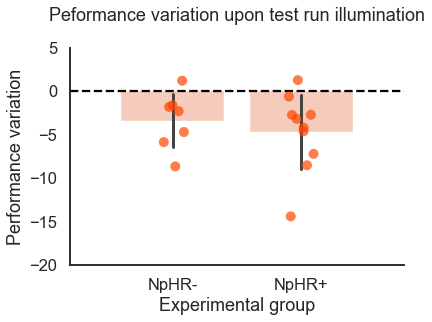

In [24]:
plt.Figure(figsize=(7,7))
sns.set(style='white', context='talk')

# Add bars
g = sns.barplot(data=perf_no_vs_test_diffs, x='group', y='performance',
           ci='sd', dodge=True, errwidth=3, palette=['orangered', 'orangered'], alpha=.3)

# Add individual dots
g = sns.stripplot(
    x='group', y='performance', hue='group',
    data=perf_no_vs_test_diffs, order=['CTRL', 'NPHR'],
    alpha=.7, s=10,
    palette=['orangered', 'orangered'],
)

# Add horizontal line (= zero deviation)
plt.axhline(0, 0, 2, linestyle='dashed', color='black')

# Add specs
g.set(ylabel='Performance variation', xlabel='Experimental group',
     title='Peformance variation upon test run illumination\n',
     xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'], xlim=[-.8,1.8], ylim=[-20, 5])
g.legend_.remove()
sns.despine()

In [25]:
normality_testing = {}
for group, data in perf_no_vs_test_diffs.groupby(['group'])['performance']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)

normality_testing = pd.Series(normality_testing)
normality_testing

CTRL    (0.9674891233444214, 0.8797985315322876)
NPHR    (0.9258499145507812, 0.4083336889743805)
dtype: object

In [26]:
from scipy.stats import ttest_ind
ctrl_var = perf_no_vs_test_diffs[perf_no_vs_test_diffs['group']=='CTRL']
nphr_var = perf_no_vs_test_diffs[perf_no_vs_test_diffs['group']=='NPHR']
t,p = ttest_ind(ctrl_var['performance'], nphr_var['performance'])
print(t,p)

0.6600461557265599 0.5192316496908307


In [27]:
sample_illumin = pooled_perfs[pooled_perfs['stim_condition']==1].reset_index(drop=True)

#Dropped CTRL#2 because we do not have data for the sample illumination
no_illumin = pooled_perfs[(pooled_perfs['stim_condition']==0) & (pooled_perfs['rat']!='CTRL2')].reset_index(drop=True)

# Calculate the difference between sample illuminated trials prformances and non-illuminated trials performances
diff = sample_illumin['performance']-no_illumin['performance']
perf_no_vs_sample_diffs = pd.concat([sample_illumin[['group', 'rat']], diff], axis=1)
perf_no_vs_sample_diffs.head()

,group,rat,performance
0,CTRL,CTRL3,-1.481481
1,CTRL,CTRL4,-0.153680
2,CTRL,CTRL5,0.330688
3,CTRL,CTRL6,-1.939153
4,CTRL,CTRL7,0.537518


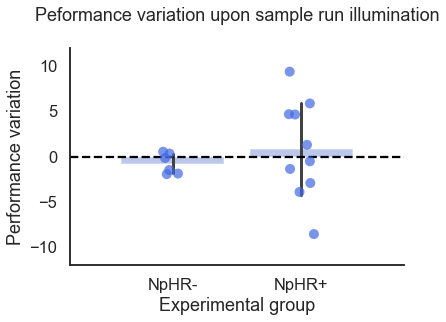

In [28]:
plt.Figure(figsize=(5,7))
sns.set(style='white', context='talk')

# Add bars
g = sns.barplot(data=perf_no_vs_sample_diffs, x='group', y='performance',
           ci='sd', errwidth=3, palette=['royalblue', 'royalblue'], alpha=.4)
# Add individual dots
g = sns.stripplot(
    x='group', y='performance', hue='group',
    data=perf_no_vs_sample_diffs,
    alpha=.7, s=10,
    palette=['royalblue', 'royalblue'],
    order=['CTRL', 'NPHR']
)
# Add horizontal line (= zero deviation)
plt.axhline(0, 0, 2, linestyle='dashed', color='black')

# Add specs
g.set(ylabel='Performance variation', xlabel='Experimental group',
     title='Peformance variation upon sample run illumination\n',
     xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'], xlim=[-.8,1.8], ylim=[-12, 12])
g.legend_.remove()
sns.despine()

#### <font color='darkorange'> Correlation between combined performances

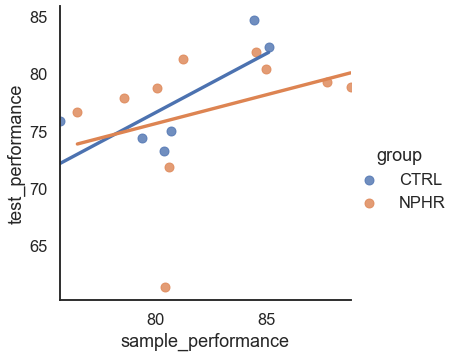

In [29]:
sample = pooled_perfs[pooled_perfs['stim_condition']==1]
test = pooled_perfs.loc[(pooled_perfs['stim_condition']==3) & (pooled_perfs['rat']!='CTRL2')]
test=test.sort_values(by='rat').reset_index(drop=True)
sample = sample.rename(columns={'performance':'sample_performance'}).sort_values(by='rat').reset_index(drop=True)
sample['test_performance']=test['performance']

sns.set(style='white', context='talk')
sns.lmplot(data=sample, x='sample_performance', y='test_performance', hue='group', 
           ci=None, height=5)
sns.despine()

#### <font color='darkorange'>  Combined Performance across groups

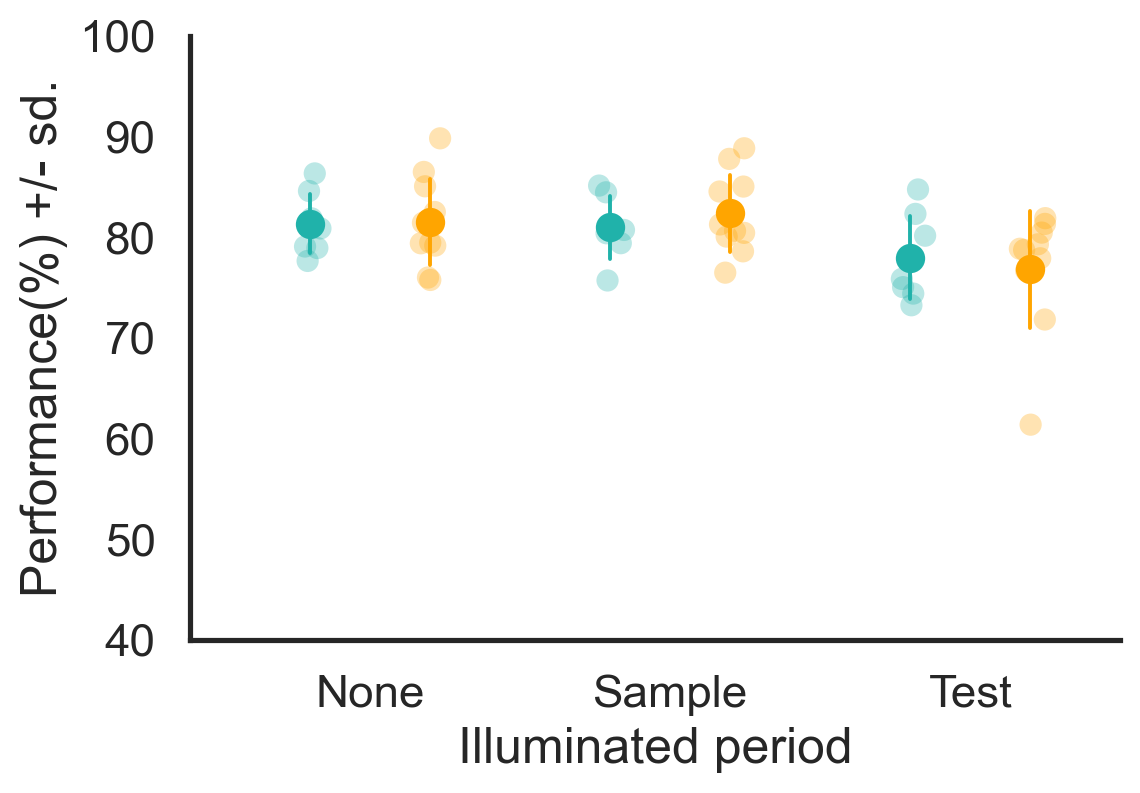

In [30]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4),dpi=200)

# Individual data points
g = sns.stripplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs, dodge=2, jitter=.1, alpha=.3, s=8,
    palette=['lightseagreen', 'orange'],
)

# Means
sns.pointplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs, dodge=.4, join=False,            
    markers="o", scale=.8, ci="sd", errwidth=1.4,
    palette=['lightseagreen', 'orange'],
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(40, 100), xlim=(-0.6, 2.5), xticklabels=['None', 'Sample', 'Test']
)
g.legend_.remove()
sns.despine()

In [31]:
# No illumination
from scipy.stats import mannwhitneyu
u, p = mannwhitneyu(x=ctrl_no['performance'], y=nphr_no['performance'])
print('No illumination: '+str(u)+', '+str(p))

# Sample illumination
u, p = mannwhitneyu(x=ctrl_sample['performance'], y=nphr_sample['performance'])
print('Sample illumination: '+str(u)+', '+str(p))

# Test Illumination
u, p = mannwhitneyu(x=ctrl_test['performance'], y=nphr_test['performance'])
print('Test Illumination: '+str(u)+', '+str(p))

No illumination: 30.0, 0.47837491816686856
Sample illumination: 24.0, 0.2754010062914416
Test Illumination: 35.0, 0.4805413319725864


#### <font color='darkorange'>  Session performances distribution during the illumination protocol

In [33]:
session_perfs.head()

,group,rat,session,stim_condition,performance
0,CTRL,CTRL2,2020-02-07T14_40_27,0,50.000000
1,CTRL,CTRL2,2020-02-07T14_40_27,3,71.428571
2,CTRL,CTRL2,2020-02-08T10_24_17,0,71.428571
3,CTRL,CTRL2,2020-02-08T10_24_17,3,100.000000
4,CTRL,CTRL2,2020-02-09T10_17_11,0,100.000000


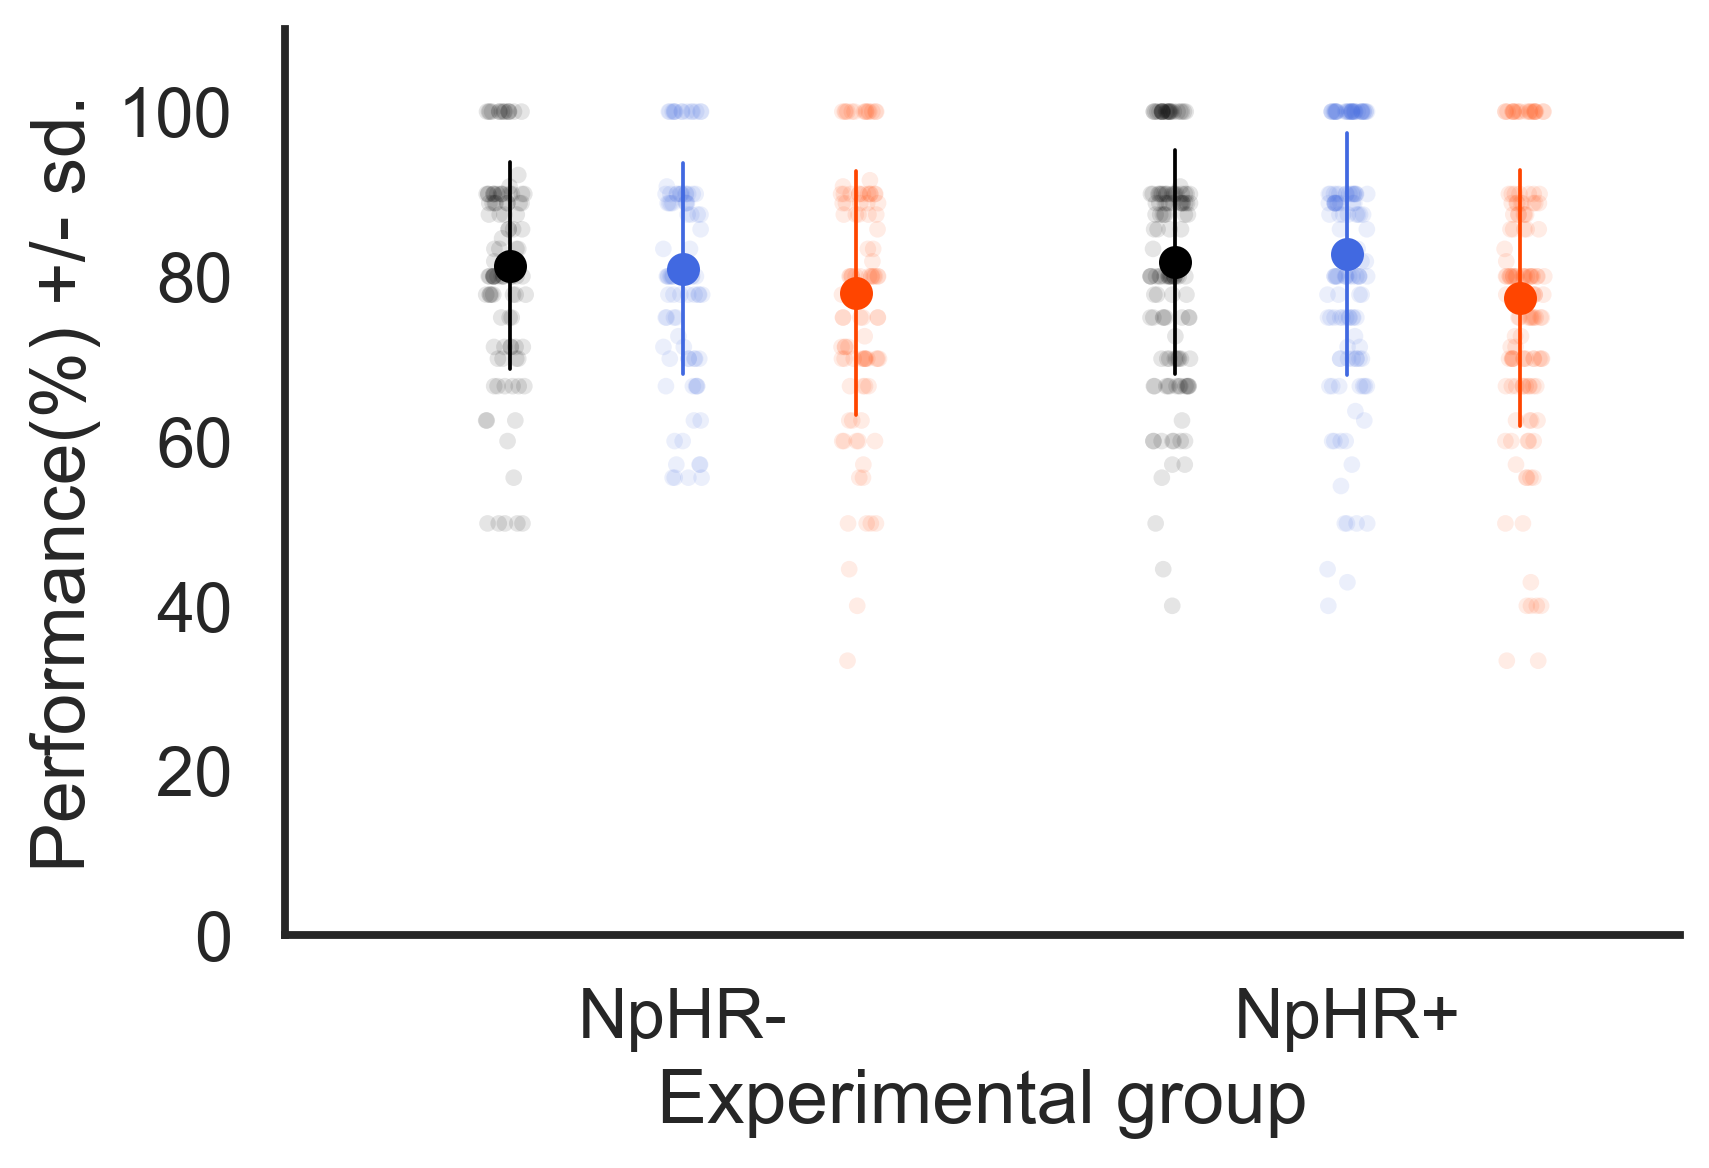

In [46]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4),dpi=300)

g = sns.stripplot(
    data=session_perfs,
    x='group', y='performance', hue='stim_condition',
    dodge=2, jitter=.09,
    alpha=.2, s=4,
    palette=['black', 'royalblue', 'orangered']
)

# Means
sns.pointplot(
       x='group', y='performance', hue='stim_condition',
        data=session_perfs,
        dodge=.52, join=False,       
        markers="o", scale=.6, linewidth=1.5,
        ci="sd", errwidth=.9,
        palette=['black', 'royalblue', 'orangered']
)
g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Experimental group',
    ylim=(0, 110), xlim=(-0.6, 1.5), xticklabels=['NpHR-', 'NpHR+'])
# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()
sns.despine()

### <font color='royalblue'> Correlations between session performances

In [35]:
session_perfs['session_nr']=""
session_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition']).apply(add_session_nr)
session_perfs = session_perfs[session_perfs['session_nr']<=15] #Removes the two final sessions of NPHR6

In [36]:
pv_session_perfs = session_perfs.pivot_table(
    values='performance', 
    columns='stim_condition', 
    index=['group','rat','session_nr'],
    dropna=True).reset_index()

In [37]:
pv_session_perfs.rename(columns={0:'no', 1:'sample', 3:'test'}, inplace=True)
pv_session_perfs.head()

stim_condition,group,rat,session_nr,no,sample,test
0,CTRL,CTRL2,1,50.000000,NaN,71.428571
1,CTRL,CTRL2,2,71.428571,NaN,100.000000
2,CTRL,CTRL2,3,100.000000,NaN,62.500000
3,CTRL,CTRL2,4,83.333333,NaN,100.000000
4,CTRL,CTRL2,5,85.714286,NaN,90.909091


##### No illumination vs. Test illumination

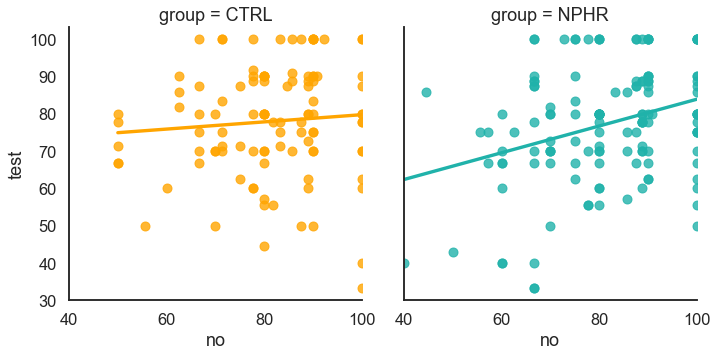

In [38]:
sns.set(style='white', context='talk')
sns.lmplot(data=pv_session_perfs, col='group', x='no', y='test', hue='group',
           col_order=['CTRL', 'NPHR'], ci=None, palette=['orange', 'lightseagreen'],height=5)
sns.despine()

##### No illumination vs. Sample illumination

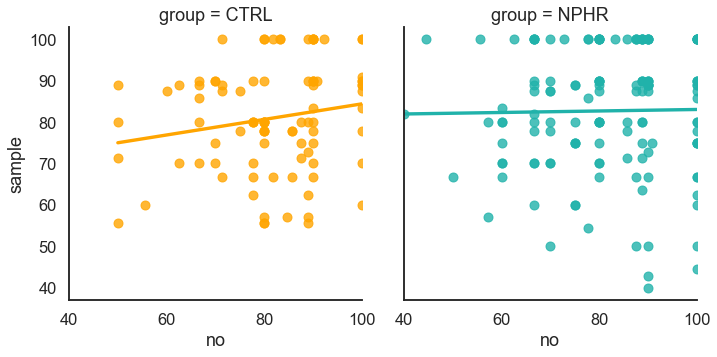

In [39]:
sns.set(style='white', context='talk')
sns.lmplot(data=pv_session_perfs, col='group', x='no', y='sample', hue='group', 
           col_order=['CTRL', 'NPHR'], ci=None, palette=['orange', 'lightseagreen'],height=5)
sns.despine()

##### Test illumination vs. Sample illumination

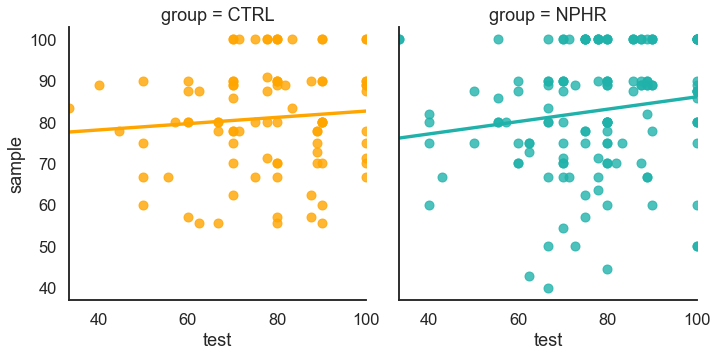

In [40]:
sns.set(style='white', context='talk')
sns.lmplot(data=pv_session_perfs, col='group', x='test', y='sample', hue='group', 
           col_order=['CTRL', 'NPHR'], ci=None, palette=['orange', 'lightseagreen'],height=5)
sns.despine()

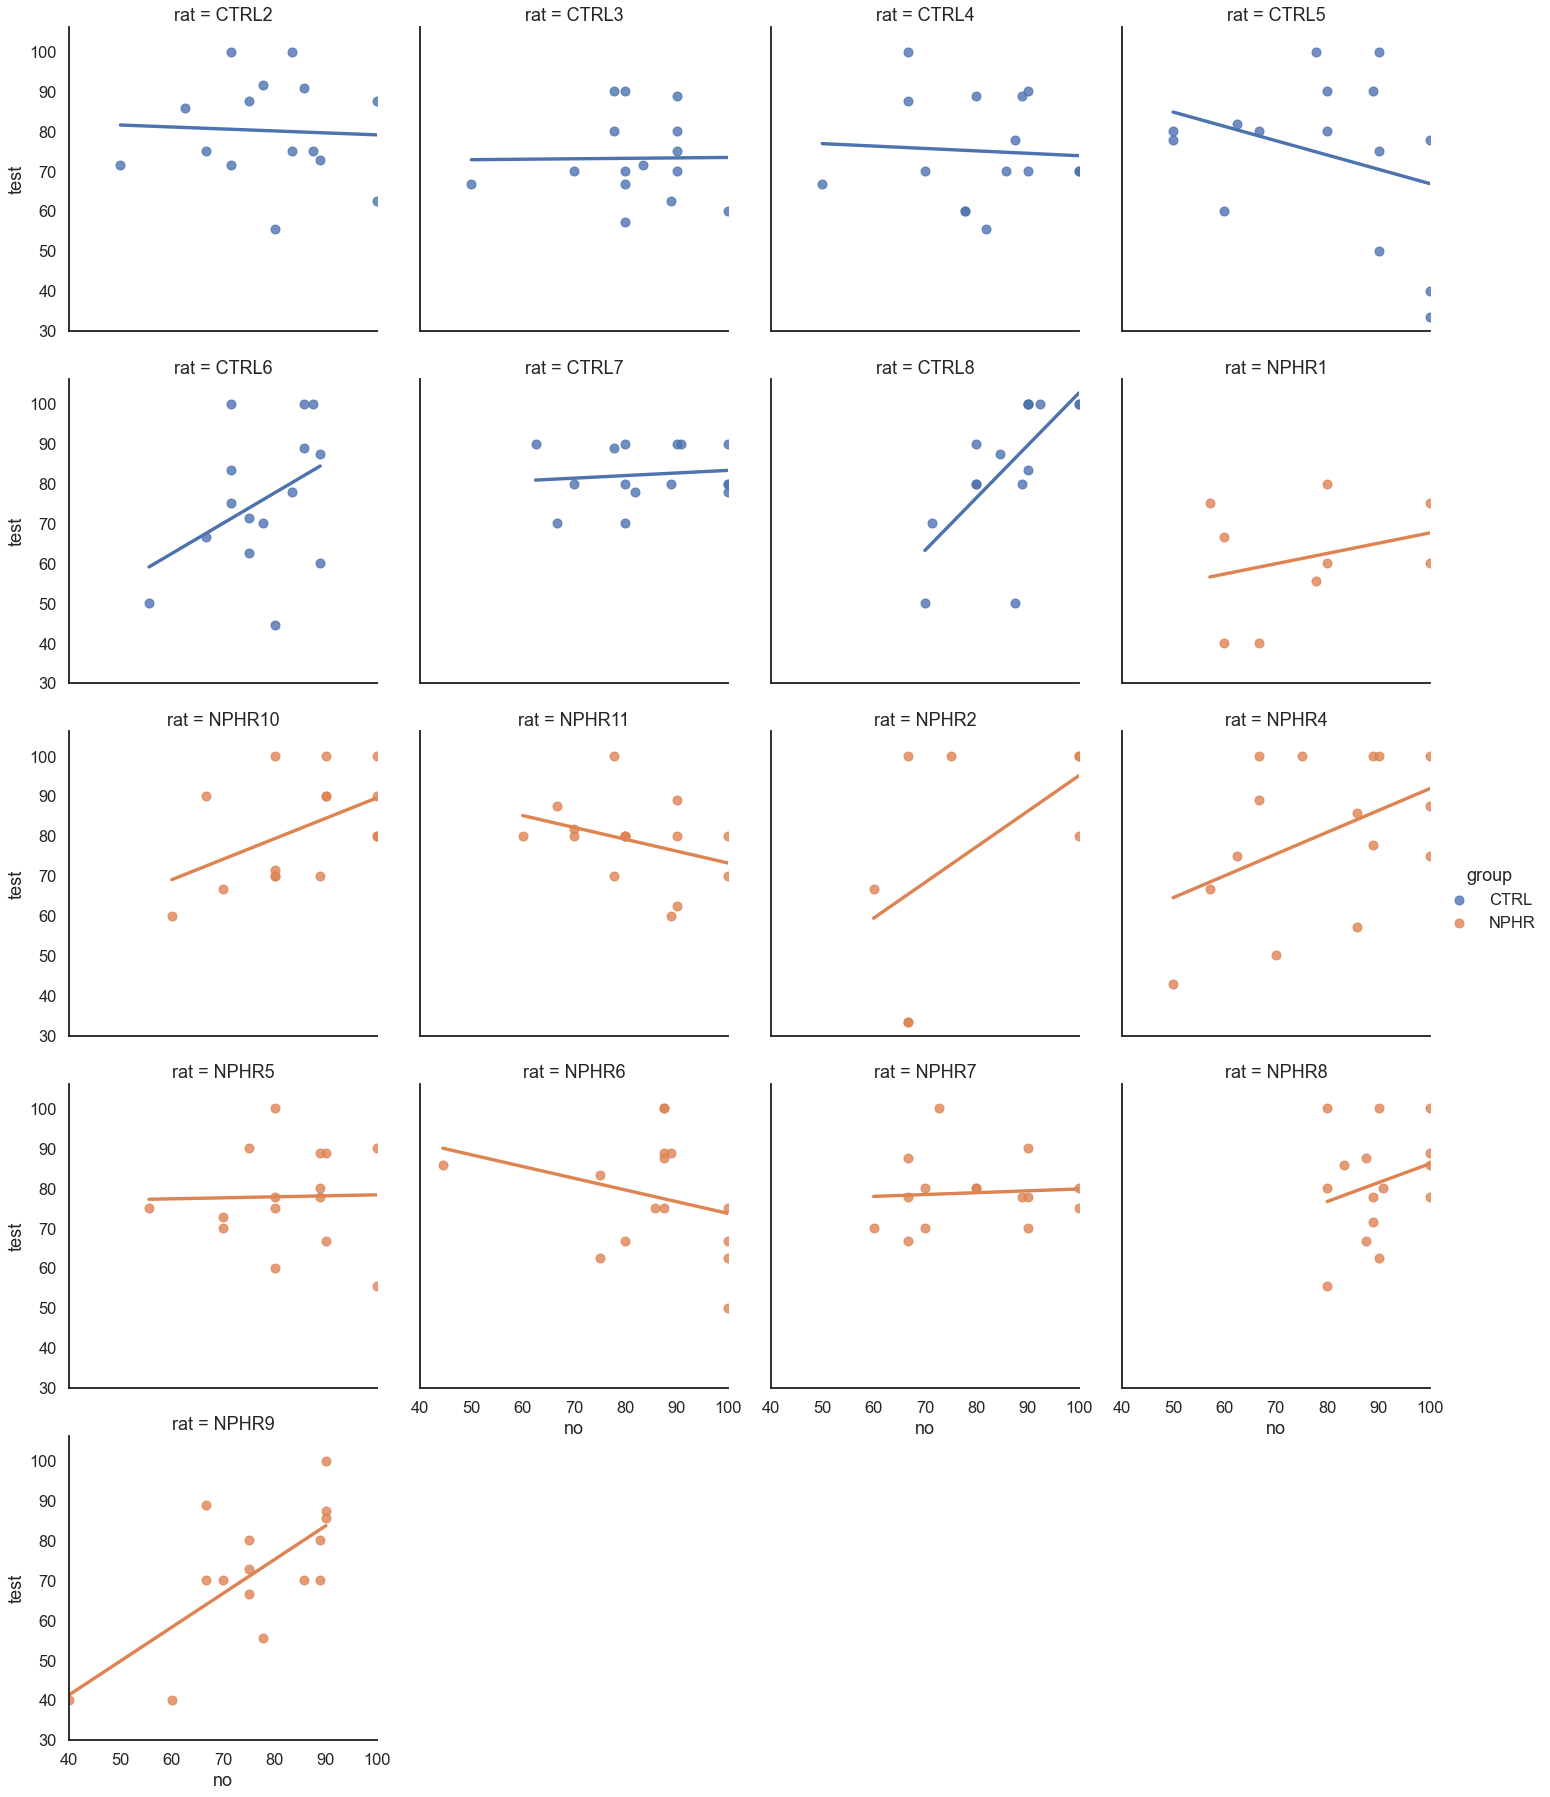

In [41]:
sns.lmplot(data=pv_session_perfs, col='rat', x='no', y='test', hue='group', col_wrap=4, ci=None)